### Loading Data

In [2]:
from load_data import *
train_images, train_labels, val_images, val_labels, test_images, test_labels = load_n_images(1200,42)

In [ ]:
# plot a frequency histogram of the training labels, with increasing color intensity
for i in range(10):
    plt.hist(train_labels[train_labels==i], bins=range(11), color=(0, 0, i/10), alpha=0.7, rwidth=0.85)
plt.title('Frequency Histogram of Training Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

# plot a frequency histogram of the validation labels, with increasing color intensity
for i in range(10):
    plt.hist(val_labels[val_labels==i], bins=range(11), color=(0, 0, i/10), alpha=0.7, rwidth=0.85)
plt.title('Frequency Histogram of Validation Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

# plot a frequency histogram of the testing labels, with increasing color intensity
for i in range(10):
    plt.hist(test_labels[test_labels==i], bins=range(11), color=(0, 0, i/10), alpha=0.7, rwidth=0.85)
plt.title('Frequency Histogram of Testing Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def visualize_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

visualize_image(train_images[0].squeeze())  # select which image to visualize
visualize_image(test_images[0].squeeze())  # select which image to visualize

### Fitting Neural Network Models

In [71]:
# import the necessary packages
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd

def create_cnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    return model

def create_rnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(layers.LSTM(64))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax')) 
    return model

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def create_transformer_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Reshape input to (batch_size, sequence_length, embedding_dim)
    x = layers.Reshape((28, 28))(inputs)  # Assuming input shape is (28, 28, 1)

    # Adding a dense layer to project into embedding dimension
    x = layers.Dense(128)(x)  

    # Apply Transformer Block
    x = TransformerBlock(embed_dim=128, num_heads=4, ff_dim=128)(x)

    # Global Average Pooling to reduce sequence length dimension
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(10, activation="softmax")(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

def one_nn(model,epochs,batch_size,train_images,train_labels,val_images,val_labels,test_images,test_labels):
    model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(val_images, val_labels))
    test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)
    print(f"Testing loss: {test_loss:.4f}")
    print(f"Testing accuracy: {test_accuracy:.4f}")
    predictions = model.predict(test_images)
    confidence = np.max(predictions, axis=1)
    average_confidence = np.mean(confidence)
    print(f"Average confidence of predictions: {average_confidence:.4f}")
    return predictions, confidence

def binning(predictions,confidence,test_labels,bin_num=11,rf=False):
    if rf:
        df = pd.DataFrame({'Prediction': predictions, 'confidence': confidence, 'True Label': test_labels})
    else:
        df = pd.DataFrame({'Prediction': np.argmax(predictions, axis=1), 'confidence': confidence, 'True Label': test_labels})
    df['accuracy'] = df['Prediction'] == df['True Label']
    bins = np.linspace(0, 1, bin_num)
    df['bins'] = pd.cut(df['confidence'], bins=bins)
    # calculate the accuracy of the model: group by the bins and calculate the mean of the accuracy
    accuracy = df.groupby('bins')[['accuracy', 'confidence']].mean().reset_index()
    n_count = df.groupby('bins')[['accuracy']].count().reset_index()
    n_count.rename(columns={'accuracy': 'count'}, inplace=True)
    accuracy = accuracy.merge(n_count, on='bins')
    return accuracy

models_dict = {'cnn': create_cnn_model, 'rnn': create_rnn_model, 'transformer': create_transformer_model}
dfs = pd.DataFrame()

for model_name, model_func in models_dict.items():
    if model_name == 'cnn':
        input_shape = (28, 28, 1)  # MNIST images are 28x28 pixels with 1 channel
    elif model_name == 'rnn':
        input_shape = (28, 28)  # MNIST images are 28x28 pixels as a sequence
    elif model_name == 'transformer':
        input_shape = (28, 28, 1)  # MNIST images are 28x28 pixels with 1 channel
    
    model = model_func(input_shape)
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    for epoch, batch in [[16,32], [32,64], [64,128]]:
        predictions, confidence = one_nn(model, epoch, batch, train_images, train_labels, val_images, val_labels, test_images, test_labels)
        df = binning(predictions, confidence, test_labels, bin_num=11)
        df['model_batch'] = model_name + '_Epoch' + str(epoch) + '_Batch' + str(batch)
        dfs = pd.concat([dfs, df])

Epoch 1/16
22/22 [==============================] - 1s 13ms/step - loss: 6.0275 - accuracy: 0.3541 - val_loss: 1.7017 - val_accuracy: 0.5422
Epoch 2/16
22/22 [==============================] - 0s 8ms/step - loss: 1.1158 - accuracy: 0.6489 - val_loss: 0.8393 - val_accuracy: 0.7600
Epoch 3/16
22/22 [==============================] - 0s 9ms/step - loss: 0.5586 - accuracy: 0.8119 - val_loss: 0.7244 - val_accuracy: 0.7867
Epoch 4/16
22/22 [==============================] - 0s 8ms/step - loss: 0.3306 - accuracy: 0.9067 - val_loss: 0.6221 - val_accuracy: 0.8533
Epoch 5/16
22/22 [==============================] - 0s 8ms/step - loss: 0.1776 - accuracy: 0.9511 - val_loss: 0.5997 - val_accuracy: 0.8533
Epoch 6/16
22/22 [==============================] - 0s 8ms/step - loss: 0.1107 - accuracy: 0.9644 - val_loss: 0.5574 - val_accuracy: 0.8800
Epoch 7/16
22/22 [==============================] - 0s 8ms/step - loss: 0.0486 - accuracy: 0.9896 - val_loss: 0.5955 - val_accuracy: 0.8622
Epoch 8/16
22/22 [=

In [90]:
# let's do a Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# flatten the images
train_images_flat = train_images.reshape(train_images.shape[0], 28*28)
val_images_flat = val_images.reshape(val_images.shape[0], 28*28)
test_images_flat = test_images.reshape(test_images.shape[0], 28*28)
# combine the training and validation data since we are using cross validation
train_images_flat = np.concatenate((train_images_flat, val_images_flat))
# combine the training and validation labels
train_labels = np.concatenate((train_labels, val_labels))
test_images_flat = test_images.reshape(test_images.shape[0], -1)

from sklearn.decomposition import PCA

# Apply PCA to reduce to 100 dimensions
pca = PCA(n_components=100)
pca.fit(train_images_flat)
train_images_pca = pca.transform(train_images_flat)
test_images_pca = pca.transform(test_images_flat)

# create the model
rf = RandomForestClassifier(n_estimators=50, random_state=42)

param_grid = {
    'max_features': ['sqrt', 20, 50],
    'max_depth': [None, 20, 50]  # Different choices for the number of features
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
# Fit the model using GridSearchCV to find the best parameters
grid_search.fit(train_images_pca, train_labels)

# Get the best model from grid search
best_rf = grid_search.best_estimator_
# Predict using the best model
predictions_rf = best_rf.predict(test_images_pca)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ..................max_depth=None, max_features=sqrt; total time=   0.2s
[CV] END ..................max_depth=None, max_features=sqrt; total time=   0.2s
[CV] END ..................max_depth=None, max_features=sqrt; total time=   0.2s
[CV] END ....................max_depth=None, max_features=20; total time=   0.4s
[CV] END ....................max_depth=None, max_features=20; total time=   0.4s
[CV] END ....................max_depth=None, max_features=20; total time=   0.4s
[CV] END ....................max_depth=20, max_features=sqrt; total time=   0.2s
[CV] END ....................max_depth=20, max_features=sqrt; total time=   0.3s
[CV] END ....................max_depth=20, max_features=sqrt; total time=   0.2s
[CV] END ......................max_depth=20, max_features=20; total time=   0.4s
[CV] END ......................max_depth=20, max_features=20; total time=   0.4s
[CV] END ....................max_depth=None, max_

In [92]:
# calculate the accuracy
accuracy_rf = accuracy_score(test_labels, predictions_rf)
print(f"Testing accuracy: {accuracy_rf:.4f}")

# calculate the confidence using predict_proba
confidence_rf = np.max(best_rf.predict_proba(test_images_pca), axis=1)

df_rf = binning(predictions_rf, confidence_rf, test_labels, bin_num=11,rf=True)
df_rf['model_batch'] = 'RandomForest'
dfs = pd.concat([dfs, df_rf])
dfs.to_csv('dfs2.csv', index=False)

Testing accuracy: 0.8533


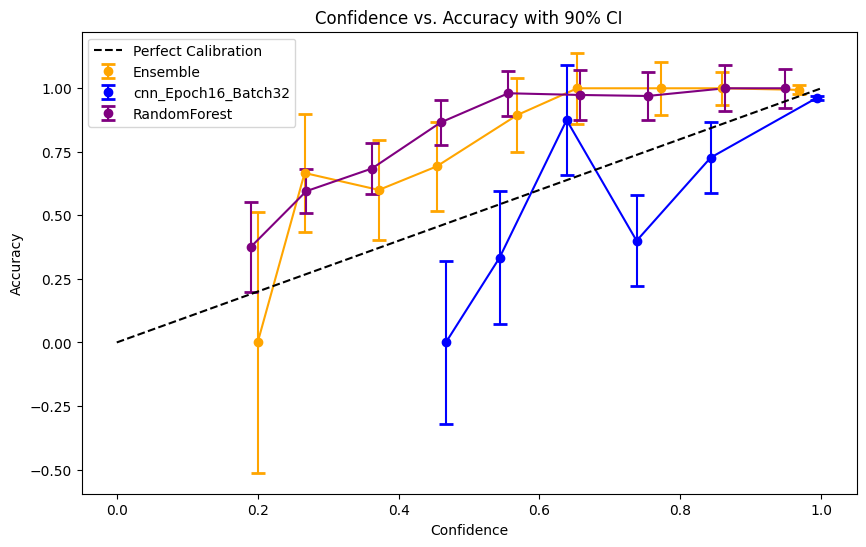

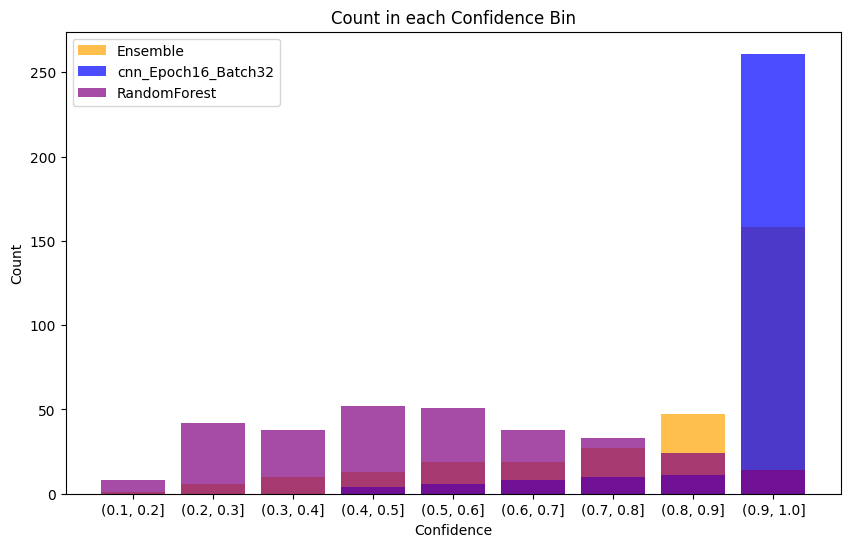

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_confidence_vs_accuracy(dfs):
    # Filter out bins with count = 0 to avoid division by zero
    dfs = dfs[dfs['count'] > 0]

    # Calculate the standard error for each bin
    dfs['std_err'] = np.sqrt(dfs['confidence'] * (1 - dfs['confidence']) / dfs['count'])

    # Calculate the 90% confidence interval (CI) using the standard error with t-distribution
    dfs['ci'] = dfs['std_err'] * norm.ppf(0.90)

    # Plot the confidence vs. accuracy with error bars for each model
    models = dfs['model_batch'].unique()
    # colors = {'cnn_Epoch16_Batch32': 'blue', 'cnn_Epoch32_Batch64': 'blue', 'cnn_Epoch64_Batch128': 'blue',
    #             'rnn_Epoch16_Batch32': 'green', 'rnn_Epoch32_Batch64': 'green', 'rnn_Epoch64_Batch128': 'green',
    #             'transformer_Epoch16_Batch32': 'red', 'transformer_Epoch32_Batch64': 'red', 'transformer_Epoch64_Batch128': 'red',
    #             'RandomForest': 'purple'}
    colors = {'cnn_Epoch16_Batch32': 'blue', 'RandomForest': 'purple',
              'Ensemble': 'orange'}
    
    plt.figure(figsize=(10, 6))
    
    for model in models:
        df_model = dfs[dfs['model_batch'] == model]
        plt.errorbar(df_model['confidence'], df_model['accuracy'], yerr=df_model['ci'], fmt='o', 
                     color=colors[model], capsize=5, capthick=2, label=f'{model}')
        plt.plot(df_model['confidence'], df_model['accuracy'], linestyle='-', color=colors[model])
    
    # Add a 45-degree line
    plt.plot([0, 1], [0, 1], 'r--', label='Perfect Calibration', color='black')

    # Labels and title
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.title('Confidence vs. Accuracy with 90% CI')
    plt.legend()

    # Show plot
    plt.show()

dfs = pd.read_csv('df_ensemble.csv')

plot_confidence_vs_accuracy(dfs)

# # graph by batch size = 32
# dfs_batch32 = dfs[dfs['model_batch'].str.contains('Batch32') | dfs['model_batch'].str.contains('RandomForest')]
# plot_confidence_vs_accuracy(dfs_batch32)

# # graph by batch size = 64
# dfs_batch64 = dfs[dfs['model_batch'].str.contains('Batch64')]
# plot_confidence_vs_accuracy(dfs_batch64)

# # graph by batch size = 128
# dfs_batch128 = dfs[dfs['model_batch'].str.contains('Batch128')]
# plot_confidence_vs_accuracy(dfs_batch128)

# Add a overlaid bar chart to show the count of each bin

def plot_count_in_bin(dfs):
    # Filter out bins with count = 0 to avoid division by zero
    dfs = dfs[dfs['count'] > 0]

    # Plot the count of each bin for each model
    models = dfs['model_batch'].unique()
    colors = {'cnn_Epoch16_Batch32': 'blue', 'RandomForest': 'purple',
                'Ensemble': 'orange'}
    plt.figure(figsize=(10, 6))
    
    for model in models:
        df_model = dfs[dfs['model_batch'] == model]
        plt.bar(df_model['bins'], df_model['count'], color=colors[model], alpha=0.7, label=f'{model}')
    
    # Labels and title
    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.title('Count in each Confidence Bin')
    plt.legend()

    # Show plot
    plt.show()

plot_count_in_bin(dfs)

### Varying cnn

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd

# input images from MNIST is 28x28x1 pixels
randomseed = 0
choice_of_filter = [16, 32, 64, 128, 256]
choice_of_kernel = [1, 3, 5, 7]

def create_cnn_model(input_shape, randomseed):
    # Randomly generate filter sizes and kernel sizes
    np.random.seed(randomseed)
    f1, f2, f3 = np.random.choice(choice_of_filter, 3, replace=False)
    k1, k2 = np.random.choice(choice_of_kernel, 2, replace=False)
    
    model = models.Sequential()
    model.add(layers.Conv2D(f1, (k1, k1), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(f2, (k2, k2), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(f3, (3, 3), activation='relu'))  # Keep kernel fixed here
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    return model

In [84]:
latent_train_representations = []
latent_test_representations = []

for i in range(50):
    print(f"Training model {i + 1}")
    # Create a new model with different random filters and kernels
    model = create_cnn_model(input_shape=(28, 28, 1), randomseed=i)
    
    # Compile the model
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    # Train the model on the training dataset
    model.fit(train_images, train_labels, epochs=5, batch_size=32,
              validation_data=(val_images, val_labels), verbose=2)
    
    # Create a new model that stops at the last convolutional layer
    latent_model = models.Model(inputs=model.input, outputs=model.layers[-2].output)
    
    # Get the latent representations of the train and test images
    latent_train = latent_model.predict(train_images)
    latent_test = latent_model.predict(test_images)

    # Store latent representations for later use
    latent_train_representations.append(latent_train)
    latent_test_representations.append(latent_test)

latent_train_array = np.array(latent_train_representations)
latent_test_array = np.array(latent_test_representations)

Training model 1
Epoch 1/5
22/22 - 1s - loss: 1.5525 - accuracy: 0.5304 - val_loss: 2.0230 - val_accuracy: 0.6044 - 758ms/epoch - 34ms/step
Epoch 2/5
22/22 - 0s - loss: 0.6516 - accuracy: 0.8222 - val_loss: 1.3299 - val_accuracy: 0.7111 - 282ms/epoch - 13ms/step
Epoch 3/5
22/22 - 0s - loss: 0.3816 - accuracy: 0.9141 - val_loss: 0.8001 - val_accuracy: 0.8533 - 279ms/epoch - 13ms/step
Epoch 4/5
22/22 - 0s - loss: 0.2560 - accuracy: 0.9393 - val_loss: 0.5279 - val_accuracy: 0.8933 - 278ms/epoch - 13ms/step
Epoch 5/5
22/22 - 0s - loss: 0.2262 - accuracy: 0.9393 - val_loss: 0.4443 - val_accuracy: 0.8889 - 277ms/epoch - 13ms/step
10/10 [==============================] - 0s 3ms/step
Training model 2
Epoch 1/5
22/22 - 1s - loss: 1.1027 - accuracy: 0.6533 - val_loss: 3.7442 - val_accuracy: 0.4889 - 646ms/epoch - 29ms/step
Epoch 2/5
22/22 - 0s - loss: 0.4108 - accuracy: 0.8711 - val_loss: 0.7476 - val_accuracy: 0.8044 - 314ms/epoch - 14ms/step
Epoch 3/5
22/22 - 0s - loss: 0.1730 - accuracy: 0.95

In [85]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from collections import Counter

def vote_majority(X):
    # along the second axis, find the most common element
    return np.array([Counter(column).most_common(1)[0][0] for column in X.T])

# Initialize a list to store the decision trees
decision_trees = []
prediction_trees = []
prediction_trees_probs = []

for i in range(50): # total of 50 models
    # Create a new decision tree
    tree = DecisionTreeClassifier(random_state=i)
    training_array = latent_train_array[i,:,:]
    # Fit the decision tree on the latent representations
    tree.fit(training_array, train_labels)
    # Append the decision tree to the list
    decision_trees.append(tree)

    # Predict the test labels using the decision tree
    testing_array = latent_test_array[i,:,:]
    prediction_tree = tree.predict(testing_array)
    prediction_trees.append(prediction_tree)

    # Predict the test labels using the decision tree and calculate the probabilities
    prediction_tree_probs = tree.predict_proba(testing_array)
    prediction_trees_probs.append(prediction_tree_probs)

prediction_trees = np.array(prediction_trees)
prediction_trees_probs = np.array(prediction_trees_probs)

In [86]:
# vote for the majority
rf_predictions = vote_majority(prediction_trees)
# calculate the accuracy
print(f"Testing accuracy: {accuracy_score(test_labels, rf_predictions):.4f}")
prediction_tree_probs.shape # shape 300,10
# Calculate the average probability for each class across all trees
average_probs = np.mean(prediction_trees_probs, axis=0)
# Calculate the average confidence of the predictions
average_confidences = np.max(average_probs, axis=1)
average_confidence = np.mean(average_confidences)
print(f"Average confidence of predictions: {average_confidence:.4f}")

Testing accuracy: 0.9533
Average confidence of predictions: 0.8299


In [87]:
def binning(predictions,confidence,test_labels,bin_num=11,rf=False):
    if rf:
        df = pd.DataFrame({'Prediction': predictions, 'confidence': confidence, 'True Label': test_labels})
    else:
        df = pd.DataFrame({'Prediction': np.argmax(predictions, axis=1), 'confidence': confidence, 'True Label': test_labels})
    df['accuracy'] = df['Prediction'] == df['True Label']
    bins = np.linspace(0, 1, bin_num)
    df['bins'] = pd.cut(df['confidence'], bins=bins)
    # calculate the accuracy of the model: group by the bins and calculate the mean of the accuracy
    accuracy = df.groupby('bins')[['accuracy', 'confidence']].mean().reset_index()
    n_count = df.groupby('bins')[['accuracy']].count().reset_index()
    n_count.rename(columns={'accuracy': 'count'}, inplace=True)
    accuracy = accuracy.merge(n_count, on='bins')
    return accuracy

df_ensemble = binning(rf_predictions, average_confidences, test_labels, bin_num=11,rf=True)

In [89]:
df_ensemble.to_csv('df_ensemble.csv', index=False)